In [20]:
import time
from datetime import datetime,timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys

sys.path.insert(0,"../")


from app.mlcode.utils import read_in_data, read_in_yaml, running_on_aws, setup_logging, update_yaml_config

import os
import sys
from threading import Thread
from typing import Any, Dict, List, Tuple

import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel, TCNModel
from darts.utils.missing_values import fill_missing_values
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from finta import TA
from collections import defaultdict

%pylab inline

import logging


Populating the interactive namespace from numpy and matplotlib


In [21]:
def setup_logging() -> logging.Logger:

    root = logging.getLogger()
    if root.handlers:
        for handler in root.handlers:
            root.removeHandler(handler)

    logging.basicConfig(format="%(asctime)s: : %(funcName)s  %(message)s", level=logging.INFO)

    return logging.getLogger(__name__)

In [22]:
logger = setup_logging()

In [23]:
# test

# The notebook leverages coinbase daily data
- open, low, high, close, volume
- unlike the other notebook where we have to create these daily candles

### Read in data

In [24]:
bitcoin_df = pd.read_csv("../tmp/historic_crypto_prices - bitcoin_jan_2017_sep_4_2021 copy.csv", 
    index_col=0,
    parse_dates=True)

In [25]:
bitcoin_df

,open,high,low,close,volume
date,,,,,
2017-01-01,963.66,1003.08,958.70,998.33,1.477750e+08
2017-01-02,998.62,1031.39,996.70,1021.75,2.221850e+08
2017-01-03,1021.60,1044.08,1021.60,1043.84,1.851680e+08
2017-01-04,1044.40,1159.42,1044.40,1154.73,3.449460e+08
2017-01-05,1156.73,1191.10,910.42,1013.38,5.101990e+08
...,...,...,...,...,...
2022-03-30,47455.00,47716.00,46329.00,47085.00,5.690887e+07
2022-03-31,47085.00,47680.00,45133.00,45520.00,7.928625e+07
2022-04-01,45518.00,46710.00,44180.00,46300.00,9.645929e+07


In [26]:
# [ time, low, high, open, close, volume ]
# 9/4
# 49400, 50558.75, 50025, 49942.98, 7595.48816499],

In [27]:
etherum_df = pd.read_csv("../tmp/historic_crypto_prices - etherum_jan_2017_sept_4_2021 copy.csv", 
    index_col=0,
    parse_dates=True)

In [28]:
etherum_df.tail()

,open,high,low,close,volume
date,,,,,
2022-03-30,3401.9,3449.0,3334.2,3386.1,6.521944e+07
2022-03-31,3386.1,3445.2,3262.9,3281.9,1.017839e+08
2022-04-01,3281.9,3482.9,3211.1,3456.0,8.044648e+07
2022-04-02,3456.0,3532.3,3433.2,3445.7,6.937825e+07
2022-04-03,3445.7,3581.3,3415.1,3522.2,3.323463e+07


In [29]:
sol_df = pd.read_csv("../tmp/historic_crypto_prices - sol_jan_2017_oct_18_2021.csv", 
    index_col=0,
    parse_dates=True)

In [30]:
np.max([sol_df.index.min(), pd.to_datetime('2021-01-01')])

Timestamp('2021-01-01 00:00:00')

In [31]:
matic_df = pd.read_csv("../tmp/historic_crypto_prices - matic_dec_2020_dec_2021.csv", 
    index_col=0,
    parse_dates=True)

In [32]:
matic_df.head()

,open,high,low,close,volume
date,,,,,
2020-12-14,0.02,0.02,0.02,0.02,6472765.0
2020-12-15,0.02,0.02,0.02,0.02,14597988.0
2020-12-16,0.02,0.02,0.02,0.02,13012452.0
2020-12-17,0.02,0.02,0.02,0.02,18914753.0
2020-12-18,0.02,0.02,0.02,0.02,13821146.0


In [33]:
matic_df.tail()

,open,high,low,close,volume
date,,,,,
2022-03-30,1.675019,1.726398,1.628389,1.682571,2.489822e+06
2022-03-31,1.682571,1.749888,1.607093,1.618506,3.537820e+06
2022-04-01,1.618506,1.713052,1.560000,1.695326,1.951585e+06
2022-04-02,1.695326,1.728973,1.645751,1.652997,2.271635e+06
2022-04-03,1.652997,1.713756,1.632667,1.687798,1.319833e+06


### Create the simulator

In [ ]:
class BollingerBandsSimulator:

    def __init__(self,prediction_coin, df_original, from_date, period, 
                 window, no_of_std, ml_lookback_windows,  ml_prediction_n_days, model_name="TCN", additional_dfs=[],
                 stop_loss_pct=.10, figsize=None):
        """
        df_original: The input dataframe containing candles we want to build bollinger bands from and predict.
            Assumes thes date is the index
        from_date: The start date to slice the df_original by
        period: time frequency to build candles if needed and transform timeseries dataset
        window: lookback window for bollinger bands + roling mean
        no_of_std: number of std for bollinger bands
        ml_lookback_windows: one lookback window per ML model
        ml_prediction_n_days: n days in the future to predcit
        additional_dfs: Additional DFs. Assumed to be the same dates are the df_original and have a 'close' col
        stop_loss_pct: the percent under/over our short/buy to keep a stop at
        """
        self.prediction_coin = prediction_coin
        self.df = df_original
        self.from_date = from_date
        self.period = period
        self.window = window
        self.no_of_std = no_of_std
        self.figsize = figsize
        self.ml_lookback_windows = ml_lookback_windows
        self.max_looback = max(ml_lookback_windows)
        # vars for taking / exiting positions
        self.ml_models_dict = {}
        self.have_trained_ml_models = False
        self.buy_entry_price = None
        self.short_entry_price = None
        self.ml_prediction_n_days = ml_prediction_n_days # the number of days in the future to predict
        self.additional_dfs = additional_dfs
        self.model_name = model_name # what type of ML model to train

        
        self.ml_train_cols = ['open', 'high', 'low', 'Rolling Mean', 'volume', 'macd', 'macd_signal', 'stc', 'stoch', 'rsi']
        self.pred_col = 'close'
        self.stop_loss_price = 0 # Price at which we get out of our position
        self.stop_loss_pct = stop_loss_pct # percent to trail our buy/short until we get out
        self.first_run = True # if first run, train the models longer
        self.number_of_trades = 0
        self.buy_has_crossed_mean = False
        self.short_has_crossed_mean = False
        self.ml_prediction_date_and_price = {}
        self.mode = 'no_position' # the curent position we have
        
        self.start_time = time.time()
        # trade analytics
        self.position_entry_date = None
        self.n_total_days_in_trades = 0
        self.win_and_lose_amount_dict = {
            'n_short_lost': 0,
            'n_buy_lost': 0,
            'n_short_won': 0,
            'n_buy_won': 0,
            '$_short_lost':0,
            '$_buy_lost':0,
            '$_short_won':0,
            '$_buy_won':0
        }
        

        
        
    def _scale_time_series_df_and_time_cols(self, input_df,  time_cols = ['year', 'month', 'day']):
        ts_transformers = {}
        ts_stacked_series = None
        ts_transformers, ts_stacked_series = self._scale_time_series_df(input_df)
            
        
        # build year and month and day series:
        for col in time_cols:
            transformer = Scaler()
            transformed_series = transformer.fit_transform(datetime_attribute_timeseries(ts_stacked_series, attribute=col))
            ts_transformers[col] = transformer    

            ts_stacked_series = ts_stacked_series.stack(transformed_series)
             

        return ts_transformers, ts_stacked_series, TimeSeries.from_series(input_df[self.pred_col],  freq=self.period)
    
    def _scale_time_series_df(self, input_df, use_pred_col=False):
        """
        Scale an input time series col from 0 to 1
        
        input_df: the DF that contains the col
        use_pred_col: if we are transforming additional DFs, we can use the pred col 'close' for them
        """
        ts_transformers = {}
        ts_stacked_series = None
        cols_to_transform = self.ml_train_cols.copy()
        # if we have additional DFs, we can include their close price
        if use_pred_col:
            cols_to_transform.append(self.pred_col)
        for col in cols_to_transform:
            transformer = Scaler()

            transformed_series = transformer.fit_transform(fill_missing_values(TimeSeries.from_series(input_df[col],
                                                                                                      freq=self.period)))
            ts_transformers[col] = transformer    

            if ts_stacked_series:
                ts_stacked_series = ts_stacked_series.stack(transformed_series)

            else:
                ts_stacked_series = transformed_series
        return ts_transformers, ts_stacked_series
    
    def _add_additional_training_dfs(self, ts_stacked_series, additional_dfs, verbose = True):
        """
        Scale any additional DFs provided (such as ETHER)
        
        ts_stacked_series: the current scaled lists from the df_original provided
        additional_dfs: additional dataframes that have been sliced for the correct date
        """
        all_ts_stacked_series = None
        all_ts_transfomers = []
        for df in additional_dfs:
            additional_ts_transformers, additional_ts_stacked_series = self._scale_time_series_df(df, use_pred_col=True)
            if all_ts_stacked_series is None:
                if verbose:
                    print('last date for training additional df data', additional_ts_stacked_series.time_index[-1])
                all_ts_stacked_series = additional_ts_stacked_series.stack(ts_stacked_series)
                if verbose:
                    print("all_ts_stacked_series FIRST", all_ts_stacked_series.components)
                all_ts_transfomers.append(additional_ts_transformers)
            else:
                all_ts_stacked_series = all_ts_stacked_series.stack(additional_ts_stacked_series)
                if verbose:
                    print("all_ts_stacked_series SECOND", all_ts_stacked_series.components)
                all_ts_transfomers.append(additional_ts_transformers)
                # return "Error. More than one time series for _add_additional_training_dfs not implemented"
        return additional_ts_transformers, all_ts_stacked_series
    
    def _check_ml_prediction(self, end_time,   tcn_first_epochs=30, tcn_sub_epochs=30, nbeats_first_epochs=5,
                             nbeats_sub_epochs=5,
                             verbose = True) -> float: 
        """train ML model to predict price movement over the last self.ml_lookback_windows days 
            predicting over the next self.ml_prediction_n_days days in teh future
        end_time: the current date to predict up to
        output_chunk_length: number of predicts to make
        tcn_first_epochs: n of training epochs for the first training run
        tcn_sub_epochs: n of training epochs for subsequents training runs
        nbeats_first_epochs: first epochs 
        nbeats_sub_epochs: epochs for NBEATS model
        """        
        if not self.have_trained_ml_models: # create models once, retrain incrementally
            print("Creating ML models")
                
            for model_n in self.model_name:
                for lookback_window in self.ml_lookback_windows:
                    if model_n == "NBEATS":
                        self.ml_models_dict[str(lookback_window)+"_NBEATS"] = NBEATSModel(input_chunk_length=lookback_window, 
                                                                      output_chunk_length=self.ml_prediction_n_days,
                                                                       random_state=0,
                                                                       model_name = self.prediction_coin + str(lookback_window) + "_nbeats",
                                                                       num_blocks=4,
                                                                       layer_widths=256,
                                                                      force_reset=True,
                                                                            log_tensorboard=False)
                    elif model_n == "TCN":
                        self.ml_models_dict[str(lookback_window)+"_TCN"] = TCNModel(
                            dropout=.1,
                            random_state=0,
                                dilation_base=2, 
                            weight_norm=True,
                            kernel_size=self.ml_prediction_n_days,
                            num_filters=7,
                            num_layers=7,
                            input_chunk_length=lookback_window,
                            output_chunk_length=self.ml_prediction_n_days,
                        model_name = self.prediction_coin + str(lookback_window) + "_tcn",
                        force_reset=True,
                        log_tensorboard=False)
                    else:
                        raise ValueError 
                        print(f"Error. Incorrect input model of {self.model_name}")  
#             self.have_trained_ml_models = True 
# TODO: uncomment

        training_df = self.df[self.df.index <= pd.to_datetime(end_time)]
        # add in any additional DFs, like ETHER
        additional_dfs_sliced = []

        if len(self.additional_dfs) > 0:
            for additional_df in self.additional_dfs:
                additional_dfs_sliced.append(additional_df[additional_df.index <= pd.to_datetime(end_time)])
        # print(additional_dfs_sliced, "additional_dfs_sliced")
        print(len(additional_dfs_sliced), "LEN additional_dfs_sliced")

        # combine TS from both DFs
        ts_transformers, ts_stacked_series, train_close_series = self._scale_time_series_df_and_time_cols(training_df)
        if verbose:
            print('original DF training series',         ts_stacked_series.components)
            print('last date for training data', ts_stacked_series.time_index[-1])
        

        if len(self.additional_dfs) > 0 :
            # overwrite the ts_stacked_series var if we have additional DFS
            additional_ts_transformers, ts_stacked_series =  self._add_additional_training_dfs(ts_stacked_series, additional_dfs_sliced)
            # TODO: in the future, combine the ts_tra
            ts_transformers = {**additional_ts_transformers, **ts_transformers} # merge dicts
        
        if verbose:
            print('all series now stacked', ts_stacked_series.components)


        # train the model & make predictions
        all_predictions = []
        # threads to start
        threads_dict = {}

        def train_model(model, train_close_series, ts_stacked_series, epochs):
            model.fit(series = train_close_series, past_covariates = [ts_stacked_series], 
                          verbose=verbose, epochs=epochs)
        

        for lookback_name, model in self.ml_models_dict.items():
            if verbose:
                print(f"Lookback name = {lookback_name}, model = {model}")
                print(str(lookback_window)+"_TCN")
                print(self.first_run, 'first run') 
            if self.first_run and "TCN" in lookback_name:
                threads_dict[str(lookback_name) + str(model.model_name)] = Thread(target=train_model, args=(model, train_close_series, ts_stacked_series, tcn_first_epochs))
                threads_dict[str(lookback_name) + str(model.model_name)].start()
                # model.fit(series = train_close_series, past_covariates = [ts_stacked_series], 
                #           verbose=verbose, epochs=tcn_first_epochs)
            elif self.first_run and "_NBEATS" in lookback_name:
                threads_dict[str(lookback_name) + str(model.model_name)] = Thread(target=train_model, args = (model, train_close_series, ts_stacked_series, nbeats_first_epochs))
                threads_dict[str(lookback_name) + str(model.model_name)].start()
                
                # model.fit(series = train_close_series, past_covariates = [ts_stacked_series], 
                #           verbose=verbose, epochs=nbeats_first_epochs)   
            elif "_NBEATS" in lookback_name:
                threads_dict[str(lookback_name) + str(model.model_name)] =Thread(target=train_model, args = (model, train_close_series, ts_stacked_series, nbeats_sub_epochs))
                threads_dict[str(lookback_name) + str(model.model_name)].start()
                
                # model.fit(series = train_close_series, past_covariates = [ts_stacked_series], 
                #           verbose=verbose, epochs=nbeats_sub_epochs)                
            elif "_TCN" in lookback_name:
                threads_dict[str(lookback_name) + str(model.model_name)] = Thread(target=train_model, args = (model, train_close_series, ts_stacked_series, tcn_sub_epochs))
                threads_dict[str(lookback_name) + str(model.model_name)].start()
                # model.fit(series = train_close_series, past_covariates = [ts_stacked_series], 
                #           verbose=verbose, epochs=tcn_sub_epochs)
        # block until all models are trained
        for k,v in threads_dict.items():
            v.join()
        # with models trained, make predictions.
        for lookback_name, model in self.ml_models_dict.items():
            # print(model, "Model")
        
            ml_prediction = model.predict(n=self.ml_prediction_n_days, 
                    series=train_close_series, past_covariates = [ts_stacked_series]).last_value() # grab the last value
            print(f" Lookback = {lookback_name} Prediction = {ml_prediction}")
            all_predictions.append(ml_prediction)
        self.first_run = False

        
        return np.mean(all_predictions) # average the predictions
        

    def _calculate_positions(self):
        self.df['Position'] = None
        self.df['Mode'] = None
        self.df['ML_Future_Prediction']=None

        
        
        
        for index in range(len(self.df)):
            
            row = self.df.iloc[index]
            prev_row = self.df.iloc[index - 1]
            
            
            if pd.to_datetime(row.name) < self.prediction_start: # lookback windows needed for ML model
                self.df.iloc[index, self.df.columns.get_loc('Mode')] =  self.mode
                continue 
                    
            if index == 0:
                self.df.iloc[index, self.df.columns.get_loc('Mode')] =  self.mode
                continue
            
            # update stop loss
            if self.mode == 'buy' and (1-self.stop_loss_pct)*row['close'] > self.stop_loss_price:
                self.stop_loss_price = (1-self.stop_loss_pct)*row['close']
                print(f"Updating stop loss to {self.stop_loss_price}")
                print(row['close'], 'row close')
            
            # if self.mode == 'short' and (1+self.stop_loss_pct)*row['close'] < self.stop_loss_price:
            #     self.stop_loss_price = (1+self.stop_loss_pct)*row['close']
            #     print(f"Updating stop loss to {self.stop_loss_price}")
            #     print(row['close'], 'row close')

                                                           
            
            # check if we've previously crossed the mean trailing price
            if self.mode == 'buy'  and row['close'] > row['Rolling Mean']:
                self.buy_has_crossed_mean = True
                
#             if self.mode == 'short'  and row['close'] < row['Rolling Mean']:
#                 self.short_has_crossed_mean = True
            

                
            # stop loss, get out of buy position
            if self.mode == 'buy' and self.stop_loss_price > row['close']:
                print('----')
                print('stop loss activated for getting out of our buy')
                print(row.name, 'current date')
                print(row['close'], 'row close')
                print(self.stop_loss_price, 'self.stop_loss_price')
                print(self.buy_entry_price, 'self.buy_entry_price')

                self.df.iloc[index, self.df.columns.get_loc('Position')] = 1
                if index + 1  == len(self.df):
                    self.df.iloc[index, self.df.columns.get_loc('Position')] = 0 
                else:
                    self.df.iloc[index + 1, self.df.columns.get_loc('Position')] = 0 # for pct change it does a ffilll. ffill with zeros
                self._determine_win_or_loss_amount(row)
                # record keeping
                self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'buy_to_no_position'
                self.mode = 'no_position'
                buy_has_crossed_mean = False
                


            

#             # stop loss, get out of short position
#             elif self.mode == 'short' and self.stop_loss_price  < row['close'] :
#                 print('----')
#                 print('stop loss activated for getting out of our short')
#                 print(row.name, 'current date')
#                 print(row['close'], 'row close')
#                 print(self.stop_loss_price, 'self.stop_loss_price')
#                 print(self.short_entry_price, 'self.short_entry_price')

#                 self.df.iloc[index, self.df.columns.get_loc('Position')] = -1
#                 if index + 1  == len(self.df):
#                     self.df.iloc[index, self.df.columns.get_loc('Position')] = 0 
#                 else:
#                     self.df.iloc[index + 1, self.df.columns.get_loc('Position')] = 0 # for pct change it does a ffilll. ffill with zeros
#                 self._determine_win_or_loss_amount(row)
#                 # record keeping
#                 self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'short_to_no_position'
#                 self.mode = 'no_position'
#                 short_has_crossed_mean = False
                




            # buy -> no_position? no position is below running mean
            # or, if we are above the top band (mean reversion)
            elif self.mode == 'buy'  and (
                (row['close'] < row['Rolling Mean'] and self.buy_has_crossed_mean) or 
                (row['close'] > row['Bollinger High']) or 
                (row['close'] < row['Bollinger Low']) or 
                (row['Rolling Mean'] < self.buy_entry_price)):
                self._check_buy_to_no_position(index, row)
                    
            
            # # short -> no_position? no position if above running mean
            # # or, if we are below the bottom band (mean reversion)
            # elif self.mode == 'short'  and (
            #     (row['close'] > row['Rolling Mean'] and self.short_has_crossed_mean) or 
            #     (row['close'] < row['Bollinger Low']) or 
            #     (row['close'] > row['Bollinger High']) or
            #     row['Rolling Mean'] > self.short_entry_price):
            #     self._check_short_to_no_position(index, row)

            # buy check with ML model
            elif self.mode == 'no_position' and row['close'] < row['Bollinger Low'] and prev_row['close'] > prev_row['Bollinger Low']:
                self._check_if_we_should_buy(index, row)

#             # short?
#             elif self.mode == 'no_position' and  row['close'] > row['Bollinger High'] and prev_row['close'] < prev_row['Bollinger High']:
#                 self._check_if_we_should_short(index, row)
        
                       
            else:
                self.df.iloc[index, self.df.columns.get_loc('Mode')] = self.mode
                
                
    def _determine_win_or_loss_amount(self, row):
        """
        For position we've exited, did we win? if so, by how much
        """
        # short s


        if self.mode=='short' and self.short_entry_price  < row['close']: # stop loss for short
            lost_amount = row['close'] - self.short_entry_price
            print(f"Lost {lost_amount} on this trade")
            
            self.win_and_lose_amount_dict['n_short_lost'] += 1
            self.win_and_lose_amount_dict['$_short_lost'] += lost_amount
            

        elif  self.mode == "short" and self.short_entry_price  > row['close']: # made money

            win_amount = self.short_entry_price - row['close'] 
            print(f"Won {win_amount} on this trade")
            self.win_and_lose_amount_dict['n_short_won'] += 1
            self.win_and_lose_amount_dict['$_short_won'] += win_amount
        # end short
        # buys

        elif  self.mode=='buy' and self.buy_entry_price  > row['close']: # lost money

            lost_amount = self.buy_entry_price - row['close'] 
            print(f"Lost {lost_amount} on this trade")
            self.win_and_lose_amount_dict['n_buy_lost'] += 1
            self.win_and_lose_amount_dict['$_buy_lost'] += lost_amount

        elif self.mode=='buy' and self.buy_entry_price  < row['close']: # made money

            won_amount = row['close'] - self.buy_entry_price 
            print(f"Won {won_amount} on this trade")
            self.win_and_lose_amount_dict['n_buy_won'] += 1
            self.win_and_lose_amount_dict['$_buy_won'] += won_amount
            
        days_in_trade = row.name - self.position_entry_date
        print(days_in_trade.days, "days in trade")
        self.n_total_days_in_trades += days_in_trade.days
        
        ## info logging   
        try:
            print(f"Average days in trades = {self.n_total_days_in_trades/(self.win_and_lose_amount_dict['n_buy_won']  + self.win_and_lose_amount_dict['n_buy_lost'] + self.win_and_lose_amount_dict['n_short_won']  + self.win_and_lose_amount_dict['n_short_lost'] )}")
        except Exception:
            pass
        if self.win_and_lose_amount_dict['n_buy_won'] > 0 or self.win_and_lose_amount_dict['n_buy_lost'] > 0:
            print(f"Bat rate buy so far = {self.win_and_lose_amount_dict['n_buy_won'] / (self.win_and_lose_amount_dict['n_buy_won'] + self.win_and_lose_amount_dict['n_buy_lost'])}")
        if self.win_and_lose_amount_dict['n_short_won'] > 0 or self.win_and_lose_amount_dict['n_short_lost'] > 0:
            print(f"Bat rate short so far = {self.win_and_lose_amount_dict['n_short_won'] / (self.win_and_lose_amount_dict['n_short_won'] + self.win_and_lose_amount_dict['n_short_lost'])}")
                                       
        if self.win_and_lose_amount_dict['$_buy_won'] > 0 or self.win_and_lose_amount_dict['$_buy_lost'] > 0:
            print(f"Win rate buy so far = {self.win_and_lose_amount_dict['$_buy_won'] / (self.win_and_lose_amount_dict['$_buy_won'] + self.win_and_lose_amount_dict['$_buy_lost'])}")
        if self.win_and_lose_amount_dict['$_short_won'] > 0 or self.win_and_lose_amount_dict['$_short_lost'] > 0:
            print(f"Win rate short so far = {self.win_and_lose_amount_dict['$_short_won'] / (self.win_and_lose_amount_dict['$_short_won'] + self.win_and_lose_amount_dict['$_short_lost'])}")
        print(f"WIn / lost dict {self.win_and_lose_amount_dict}")

        
        print(f"Total days in trades = {self.n_total_days_in_trades }")

        
        # reset for sanity
        self.position_entry_date = None
                
                
    def _check_short_to_no_position(self, index, row):
        """
        While in a short position, check if we should exit
        """

        print('---------')
        print('checking if we should get out of our short position')
        print(row.name, 'current date')
        print(row['Rolling Mean'], 'mean')
        print(self.short_entry_price, 'self.short_entry_price')
        print(row['close'], 'current close')
        
        # check ML predicted trend as well
        try:
            ml_pred = self._check_ml_prediction(row.name)
        except ValueError: # don't have enough data for ML prediction
            print('Ran into not enough data ValueError for short_to_no_position')
            return
        print(ml_pred, 'ml_pred')
        if (ml_pred > row['Rolling Mean']) \
            or (ml_pred > self.short_entry_price) \
            or (row['Rolling Mean'] > self.short_entry_price):
            print('short_to_no_position')
            self.df['ML_Future_Prediction'] = ml_pred

            self.df.iloc[index, self.df.columns.get_loc('Position')] = -1
            if index +1  == len(self.df):
                self.df.iloc[index, self.df.columns.get_loc('Position')] = 0 
            else:
                self.df.iloc[index + 1, self.df.columns.get_loc('Position')] = 0 # for pct change it does a ffilll. ffill with zeros

            self._determine_win_or_loss_amount(row)
            # record keeping
            self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'short_to_no_position'
            self.mode = 'no_position'
            short_has_crossed_mean = False
        else:
            self.df.iloc[index, self.df.columns.get_loc('Mode')] = self.mode
            
    def _check_buy_to_no_position(self,  index, row):
        """
        While in a buy/long position, check if we should exit
        """
        print('---------')
        print('checking if we should get out of our buy position')
        print(row.name, 'current date')
        print(row['Rolling Mean'], 'mean')
        print(self.buy_entry_price, 'self.buy_entry_price')
        print(row['close'], 'current close')


        # check ML predicted trend as well
        try:
            ml_pred = self._check_ml_prediction(row.name)
        except ValueError: # don't have enough data for ML prediction
            print('Ran into not enough data ValueError for buy_to_no_position')
            return
        print(ml_pred, 'ml_pred')

        if (ml_pred < row['Rolling Mean']) or \
             (ml_pred < self.buy_entry_price) or \
            (row['Rolling Mean'] < self.buy_entry_price):
            print('buy_to_no_position')
            self.df['ML_Future_Prediction'] = ml_pred

            self.df.iloc[index, self.df.columns.get_loc('Position')] = 1

            if index + 1  == len(self.df):
                self.df.iloc[index, self.df.columns.get_loc('Position')] = 0 
            else:
                self.df.iloc[index + 1, self.df.columns.get_loc('Position')] = 0 # for pct change it does a ffilll. ffill with zeros

            self._determine_win_or_loss_amount(row)
            # record keeping
            self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'buy_to_no_position'
            self.mode = 'no_position'
            self.buy_has_crossed_mean = False
        else:
            self.df.iloc[index, self.df.columns.get_loc('Mode')] = self.mode

                
    def _check_if_we_should_buy(self, index, row):
        """
        Determine if we should enter a buy position
        """
        start_time = time.time()
        print('----------')
        print('buy')
        print(row.name, 'current date')
        print(row['close'], 'close')
        # check ML predicted trend as well
        try:
            ml_pred = self._check_ml_prediction(row.name)
        except ValueError: # don't have enough data for ML prediction
            print('Ran into not enough data ValueError for buy')
            self.df.iloc[index, self.df.columns.get_loc('Mode')] = self.mode
            return 9999999

        print(ml_pred, 'ml prediction day')
        print(row['Rolling Mean'], 'mean')

        if ml_pred > row['Rolling Mean']:
            print(f"ml pred higher than mean taking position")
            self.df['ML_Future_Prediction'] = ml_pred
            self.ml_prediction_date_and_price[row.name + timedelta(days=self.ml_prediction_n_days)] = ml_pred 

            self.df.iloc[index, self.df.columns.get_loc('Position')] = 0 # buy. add one to index so that pct_change works

            if index +1  == len(self.df):
                self.df.iloc[index, self.df.columns.get_loc('Position')] = 1 
            else:
                self.df.iloc[index + 1, self.df.columns.get_loc('Position')] = 1 # buy. add one to index so that pct_change works
            self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'buy'
            self.number_of_trades  += 1
            self.mode = 'buy'    
            self.buy_entry_price = row['close']
            self.stop_loss_price = row['close'] * (1-self.stop_loss_pct)
            self.position_entry_date = row.name
        else:
            self.df.iloc[index, self.df.columns.get_loc('Mode')] = self.mode
        
        end_time = time.time()
        print(f"Eval buy took {(end_time - start_time)/60} minutes")
            

            
            
    def _check_if_we_should_short(self, index, row):
        """
        Check if we should enter a short position
        """
        start_time = time.time()
        print('----------')
        print('short')
        print(row.name, 'current date')
        print(row['close'], 'close')
        # check ML predicted trend as well
        try:
            ml_pred = self._check_ml_prediction(row.name)
        except Exception as e: # don't have enough data for ML prediction
            print('Ran into not enough data ValueError for short')
            print(e)
            self.df.iloc[index, self.df.columns.get_loc('Mode')] = self.mode
            return 0

        print(ml_pred, 'ml pred day')
        print(row['Rolling Mean'], 'mean')

        if ml_pred < row['Rolling Mean']:
            print('pred 7 day lower than mean taking position')
            self.df['ML_Future_Prediction'] = ml_pred
            self.ml_prediction_date_and_price[row.name + timedelta(days=self.ml_prediction_n_days)] = ml_pred 

            self.df.iloc[index, self.df.columns.get_loc('Position')] = 0 #  short starts at the end of the day. Calculate pct_change starting tomorrow
            self.df.iloc[index + 1, self.df.columns.get_loc('Position')] = -1 #  short starts at the end of the day. Calculate pct_change starting tomorrow
            if index +1  == len(self.df):
                self.df.iloc[index, self.df.columns.get_loc('Position')] = -1
            else:
                self.df.iloc[index + 1, self.df.columns.get_loc('Position')] = -1 # buy. add one to index so that pct_change works
            self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'short'
            self.number_of_trades  += 1
            self.mode = 'short' 
            self.short_entry_price = row['close']
            self.stop_loss_price = row['close']*(1+self.stop_loss_pct)
            self.position_entry_date = row.name
        else:
            self.df.iloc[index, self.df.columns.get_loc('Mode')] = self.mode
            
        end_time = time.time()
        print(f"Eval short took {(end_time - start_time)/60} minutes")
        
    
 
    def _add_indicators(self, input_df: pd.DataFrame) -> pd.DataFrame:
        
        input_df['stc'] = TA.STC(input_df)
        input_df['stoch'] = TA.STOCH(input_df)
        input_df['rsi'] = TA.RSI(input_df, period=self.window)
        macd_df = TA.MACD(input_df)
        input_df['macd'] = macd_df['MACD']
        input_df['macd_signal'] = macd_df['SIGNAL']

        
        return input_df
        
        
   
    def _build_bollinger_bands_rsi_macd_cols(self):
        rolling_mean = self.df['close'].rolling(self.window).mean()
        rolling_std = self.df['close'].rolling(self.window).std()

        self.df['Rolling Mean'] = rolling_mean
        self.df['Bollinger High'] = rolling_mean + (rolling_std * self.no_of_std)
        self.df['Bollinger Low'] = rolling_mean - (rolling_std * self.no_of_std)
        ## add rsi
        self._add_indicators(self.df)

        
        new_additional_dfs = []
        if len(self.additional_dfs) >0: 
            for df in self.additional_dfs:
                rolling_mean = df['close'].rolling(self.window).mean()
                rolling_std = df['close'].rolling(self.window).std()

                df['Rolling Mean'] = rolling_mean
                df['Bollinger High'] = rolling_mean + (rolling_std * self.no_of_std)
                df['Bollinger Low'] = rolling_mean - (rolling_std * self.no_of_std)
                
                ## add rsi
                df = self._add_indicators(df)
                

                
                new_additional_dfs.append(df)
        self.additional_dfs = new_additional_dfs
        
    def _calculate_returns(self):
        
        self.df['Original Position'] = self.df['Position']
        self.df['Position'].fillna(method='ffill', inplace=True)
        self.df['Market Return'] = self.df['close'].pct_change()
        self.df['Strategy Return'] = self.df['Market Return'] * self.df['Position']

    def _plot_returns(self):
        self.df['Strategy Return'].cumsum().plot(figsize=self.figsize)
    
    def _slice_df(self):
        # get slice dates from ALL DFs 
        additional_dfs_min_date = np.max([df.index.min() for df in self.additional_dfs])
        slice_date = np.max([self.df.index.min(), pd.to_datetime(self.from_date), additional_dfs_min_date])
        
        self.df = self.df.loc[pd.to_datetime(slice_date):, :].copy()
        self.prediction_start = pd.to_datetime(slice_date) + timedelta(self.max_looback)
        
        sliced_additional_dfs = []
        if len(self.additional_dfs) > 0:
            for add_df in self.additional_dfs:
                sliced_df = add_df.loc[pd.to_datetime(slice_date):, :].copy()
                sliced_additional_dfs.append(sliced_df)

        self.additional_dfs = sliced_additional_dfs
        
        

    def simulate(self):
        self._slice_df()
        self._build_bollinger_bands_rsi_macd_cols()
        self._calculate_positions()
        self._calculate_returns()
        self._plot_returns()
        self.end_time = time.time()
        
        print(f" Minutes taken = {(self.end_time - self.start_time)/60}")

        return (
            self.period, 
            self.window, 
            self.no_of_std, 
            self.df['Strategy Return'].sum(),
            self.number_of_trades
        )

In [39]:

simulator = BollingerBandsSimulator(
    "btc",
    bitcoin_df, #
    from_date="2019-01-01", 
    period="24H", 
    window=5, 
    no_of_std=1.25,
    ml_lookback_windows=[15, 30, 45],
    ml_prediction_n_days=7,
    additional_dfs = [ etherum_df], #spy_df, etherum_df
    stop_loss_pct=.15,
    model_name=["TCN", "NBEATS"]
)
simulator.simulate()

----------
buy
2019-02-24 00:00:00 current date
3810.43 close
Creating ML models
1 LEN additional_dfs_sliced
original DF training series Index(['open', 'high', 'low', 'Rolling Mean', 'volume', 'macd', 'macd_signal',
       'stc', 'stoch', 'rsi', 'year', 'month', 'day'],
      dtype='object', name='component')
last date for training data 2019-02-24 00:00:00
last date for training additional df data 2019-02-24 00:00:00
all_ts_stacked_series FIRST Index(['open', 'high', 'low', 'Rolling Mean', 'volume', 'macd', 'macd_signal',
       'stc', 'stoch', 'rsi', 'close', 'open_1', 'high_1', 'low_1',
       'Rolling Mean_1', 'volume_1', 'macd_1', 'macd_signal_1', 'stc_1',
       'stoch_1', 'rsi_1', 'year', 'month', 'day'],
      dtype='object', name='component')
all series now stacked Index(['open', 'high', 'low', 'Rolling Mean', 'volume', 'macd', 'macd_signal',
       'stc', 'stoch', 'rsi', 'close', 'open_1', 'high_1', 'low_1',
       'Rolling Mean_1', 'volume_1', 'macd_1', 'macd_signal_1', 'stc_

TypeError: '<' not supported between instances of 'float' and 'NoneType'

In [10]:
simulator

In [ ]:
N


#### Visualize Trades

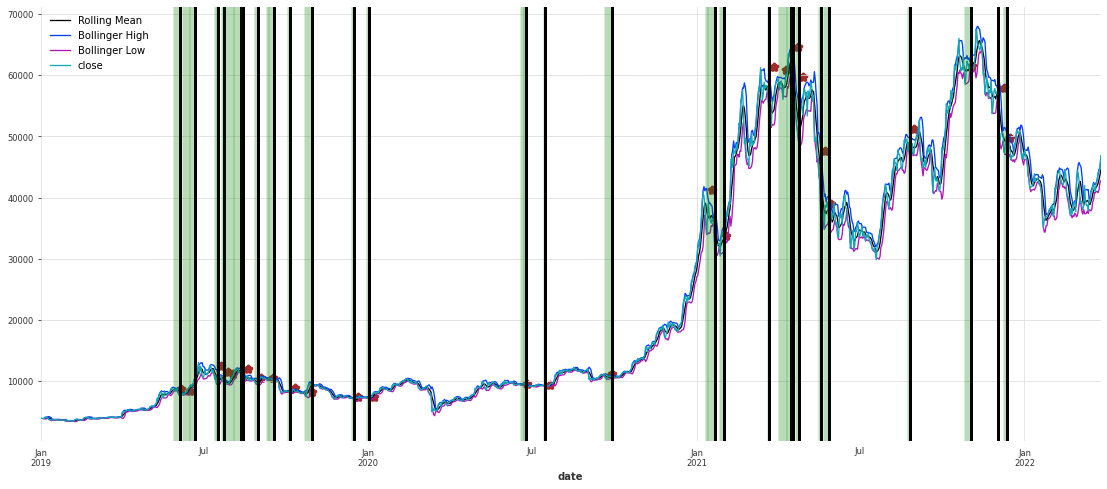

In [15]:
DATE_FILTER = '2017-10-22'
simulator.df[simulator.df.index > DATE_FILTER ]  [['Rolling Mean', 'Bollinger High', 'Bollinger Low', 'close']].plot(figsize=(19,8))

prev_pos = None
for index, pos in simulator.df[simulator.df.index > DATE_FILTER ]['Mode'].iteritems():
    if pos == "short":
        plt.axvline(index, color='red', linewidth=.3)
    if pos == "buy":
        plt.axvline(index, color='green', linewidth=.3)
    if pos == 'short_to_no_position':
        plt.axvline(index, color='black', linewidth=3)
    if pos == 'buy_to_no_position':
        plt.axvline(index, color='black', linewidth=3, label = 'buy_to_no_postiion')


for key,val in simulator.ml_prediction_date_and_price.items():
    plt.scatter(key, val, marker="*", linewidths=4, color='brown', label='predictions')

# plt.legend()

In [ ]:
# short
# 2019-11-04 00:00:00 current date
#  Lookback = 30 Prediction = 7337.89262836642
#  Lookback = 90 Prediction = 9278.555809841882
#  Lookback = 180 Prediction = 11221.047974868856
# 9279.165471025719 ml prediction 7 day
# 8554.994666666667 mean

In [ ]:
simulator.df[simulator.df.index > '2021-07-22' ] 

In [ ]:
simulator.df[simulator.df.index > '2021-08-31' ].Mode.value_counts()

In [ ]:
np.sum(simulator.df.Mode == None)